In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
import sys
import pickle
from scipy.spatial.transform import Rotation as R
from scipy.optimize import root
from math import ceil

import numpy as np

material_param = {}
material_param['ER_4043'] = {
    #ER 4043
    "200ipm": [-0.58853786,  2.36925842],
    "210ipm": [-0.57756141,  2.43079976],
    "220ipm": [-0.71905278,  2.67732977],
    "230ipm": [-0.59095092,  2.47071631],
    "240ipm": [-0.6856249,   2.19719422],
}


def v2dh_loglog(v,mode=140,material='ER_4043'):
    
    mode=int(mode)
    #print(str(mode)+'ipm')
    param = material_param[material][str(mode)+'ipm']
    logdh = param[0]*np.log(v)+param[1]
    
    dh = np.exp(logdh)
    return dh

def dh2v_loglog(dh,mode=140,material='ER_4043'):
    
    mode=int(mode)
    param = material_param[material][str(mode)+'ipm']

    logdh = np.log(dh)
    logv = (logdh-param[1])/param[0]
    
    v = np.exp(logv)
    return v

def dh2v_quadratic(dh,mode=140):

    if mode==140:
        # 140 ipm
        a=0.006477
        b=-0.2362
        c=3.339-dh
    elif mode==160:
        # 160 ipm
        a=0.006043
        b=-0.2234
        c=3.335-dh
    
    v=(-b-np.sqrt(b**2-4*a*c))/(2*a)
    return v

def v2dh_quadratic(v,mode=140):

    if mode==140:
        # 140 ipm
        a=0.006477
        b=-0.2362
        c=3.339
    elif mode==100:
        # 100ipm
        a=0.01824187
        b=-0.58723623
        c=5.68282353
    elif mode==160:
        # 160 ipm
        a=0.006043
        b=-0.2234
        c=3.335
    
    dh = a*(v**2)+b*v+c
    return dh

def distance_out(v_rat_1, h1, v_rat_2, h2, v_rat_fill, rad_wire=1.2/2):
    d = (np.pi*rad_wire**2)*(2*v_rat_fill+v_rat_1+v_rat_2)/(h1+h2)
    return d

def v_rat_out(v_rat_1, h1, v_rat_2, h2, d, rad_wire=1.2/2):
    v_rat = ((d*(h1+h2))/(2*np.pi*rad_wire**2))-((v_rat_1+v_rat_2)/2)
    return v_rat

Max dH:  5.214714713159182
Min dH:  2.724427840264497
Mean dH:  3.9695712767118394
------------------------
Layer Angle: 1.4269767924865793
Final Angle: 42.80930377459738
Point of Rotation: 209.337227729949
2.724427840264497
12.0
[0.0, 12.80685224708019, 24.965022336944404, 36.64735789499472, 47.97119004373207, 59.02042308199167, 69.85749673997593, 80.53036857850088, 91.07683355491206, 101.52732340923659]
[2.724427840264497, 3.043355200604553, 3.3461285143366495, 3.6370521831862845, 3.919048088694919, 4.19420568860224, 4.46407991131295, 4.729865037668611, 4.992502270530614, 5.252749447526049]


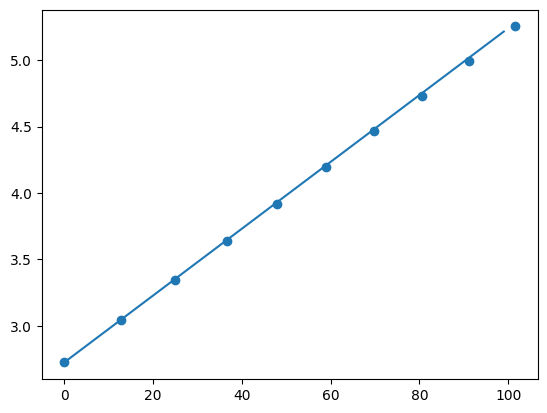

In [17]:
min_speed = 4.0
max_speed = 12.0
feed_speed = 230
material = 'ER_4043'

max_dH = v2dh_loglog(min_speed,feed_speed,material)
min_dH = v2dh_loglog(max_speed,feed_speed,material)
mean_dH = (max_dH+min_dH)/2

print('Max dH: ', max_dH)
print('Min dH: ', min_dH)
print('Mean dH: ', mean_dH)
print('------------------------')

#wall characteristics
wall_length = 100 
wall_width = 40
points_distance=0.5
num_layers = 30
vertical_shift = 0 #mm

#segment characteristics
seg_len = wall_width #mm
points_distance=0.5
points_per_segment=int(seg_len/points_distance)


#base_seg params
num_pre_seg = 2
base_seg_len = 100
base_seg_min = 0
base_seg_max = 70
work_offset = 15
points_per_base_seg = int(base_seg_len/points_distance)
base_seg_curve = np.zeros((num_pre_seg*points_per_base_seg,6))

#first baseseg
base_seg_curve[0:points_per_base_seg, 0] = np.linspace(0, base_seg_len, points_per_base_seg)
base_seg_curve[0:points_per_base_seg, 1] = base_seg_min
base_seg_curve[0:points_per_base_seg, -1] = -1

#second baseseg
base_seg_curve[points_per_base_seg:points_per_base_seg*2, 0] = np.linspace(0, base_seg_len, points_per_base_seg)
base_seg_curve[points_per_base_seg:points_per_base_seg*2, 1] = base_seg_max
base_seg_curve[points_per_base_seg:points_per_base_seg*2, -1] = -1



#rotation criteria
layer_angle = np.arcsin((max_dH-min_dH)/wall_length)
rot_point = max_dH/np.tan(layer_angle)
print('Layer Angle:', np.rad2deg(layer_angle))
print('Final Angle:', np.rad2deg(layer_angle)*num_layers)
print('Point of Rotation:', rot_point)
    



#layer gen
# curve_curved=np.zeros((num_layers**points_per_layer,6))
# base_layer = np.zeros((points_per_layer,6))


#plotting baselayer
vis_step=1

# #save as individual segments
# for seg_idx in range(num_pre_seg):
#     segment = base_seg_curve[points_per_base_seg*(seg_idx):points_per_base_seg*(seg_idx+1), :]
#     np.savetxt('slice_ER_4043/curve_sliced/slice0_'+str(seg_idx)+'.csv',segment,delimiter=',')


############# first layer ##################
# Layer gen functions
def prof(height_des, h_start, h_end, wall_length, dOffset):
    return(height_des-h_start)*wall_length/(h_end-h_start)-dOffset

def distance_func(v_t, v_w, v_t_prev, v_w_prev, v_t_fill, v_w_fill, hProfStart, hProfEnd, wall_length, dOffset):
    h = v2dh_loglog(v_t, v_w)
    hStart = v2dh_loglog(v_t_prev, v_w_prev)
    vRatStart = (v_w_prev/39.37)/(v_t_prev*0.06)
    vRatCurr = (v_w/39.37)/(v_t*0.06)
    vRatFill = (v_w_fill/39.37)/(v_t_fill*0.06)
    d_fill = distance_out(vRatStart, hStart, vRatCurr, h, vRatFill)
    d_prof = prof(h, hProfStart, hProfEnd, wall_length, dOffset)
    return d_prof-d_fill

vt_prev = max_speed
vw_prev = 230
vw_next = 230
vt_fill = 5
vw_fill = 280

#initialized with first bead params
print(min_dH)
print(vt_prev)
distances = [0.0]
heights = [min_dH]
vel_profile = [vt_prev]
cum_distance = 0



while(cum_distance<wall_length):
    sol = root(distance_func, 1, (vw_next, vt_prev, vw_prev, vt_fill, vw_fill, min_dH, max_dH, wall_length, cum_distance))
    vel_profile.append(sol.x[0])
    sol_h = v2dh_loglog(sol.x, 230)
    sol_h = sol_h[0]
    sol_d = prof(sol_h, min_dH, max_dH, wall_length, cum_distance)
    heights.append(sol_h)
    distances.append(sol_d+cum_distance)
    cum_distance = cum_distance+sol_d
    vt_prev = sol.x
print(distances)
print(heights)
fig,ax = plt.subplots(1,1)
ax.plot(np.linspace(min_dH, max_dH, 100))
ax.scatter(distances, heights)
plt.show()

[14.30283006 14.26605442 14.22889087 14.19133272 14.15337315 14.11500523
 14.0762219  14.03701596 13.99738009 13.95730688 13.91678877 13.87581811
 13.83438713 13.79248799 13.75011274 13.70725337 13.6639018  13.62004991
 13.57568955 13.53081259 13.48541088 13.43947636 13.39300107 13.34597716
 13.29839697 13.25025311 13.20153848 13.15224639 13.10237064 13.05190562
 13.00084645 12.94918917 12.89693082 12.84406977 12.79060588 12.73654082
 12.68187841 12.62662507 12.57079022 12.51438695 12.45743266 12.3999499
 12.34196739 12.28352121 12.22465629 12.16542821 12.10590536 12.04617171
 11.98633017 11.92650675]


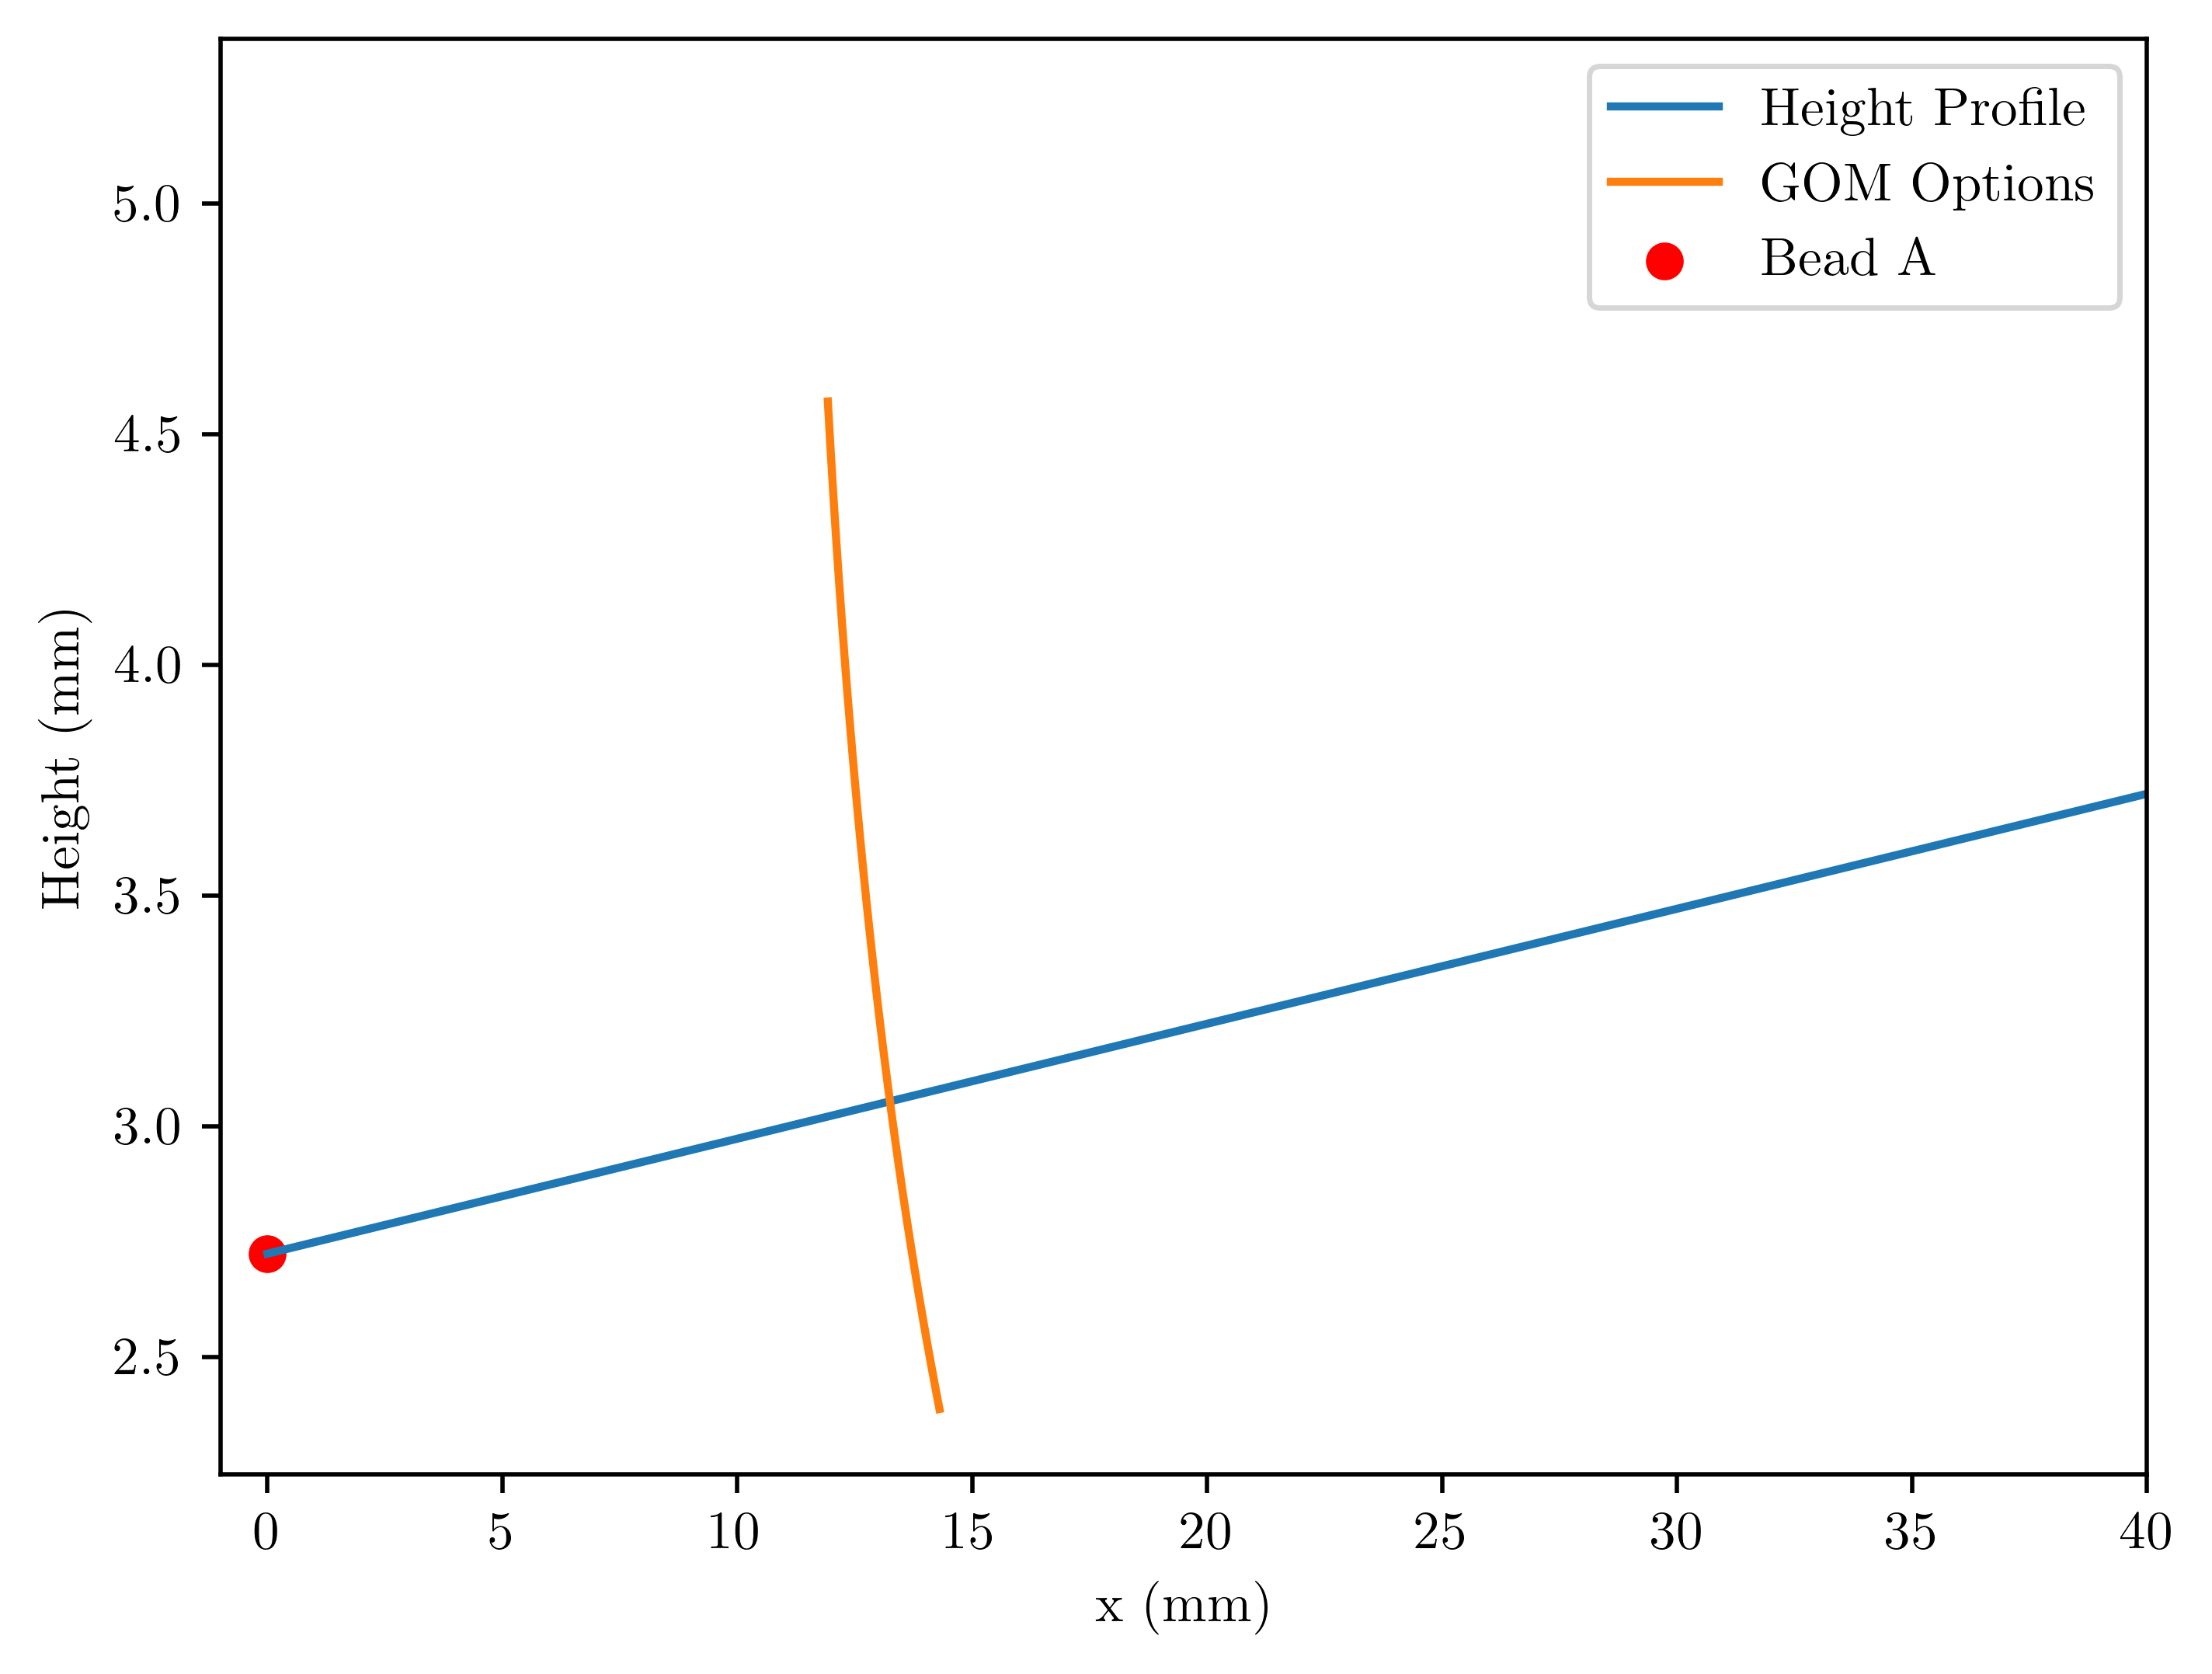

In [52]:
height_profile = [min_dH, max_dH]
x_profile = [0, 100]
v_ts = np.linspace(15,5)

v_w = 230
v_w_fill = 280
v_t_fill = 5
vRatFill = (v_w_fill/39.37)/(v_t_fill*0.06)

vRatStart = (v_w/39.37)/(v_ts[0]*0.06)
vRat = (v_w/39.37)/(v_ts*0.06)

d_s = distance_out(vRatStart, v2dh_loglog(v_ts[0], v_w), vRat, v2dh_loglog(v_ts, v_w), vRatFill, rad_wire=1.2/2)

print(d_s)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig,ax = plt.subplots(1,1)
ax.plot(x_profile, height_profile, label='Height Profile')
ax.plot(d_s, v2dh_loglog(v_ts, v_w), label = 'GOM Options')
ax.scatter(x_profile[0], height_profile[0], color = 'r', label='Bead A')
ax.legend()
ax.set_xlim([-1, 40])
fig.dpi=500
ax.set_xlabel("x (mm)")
ax.set_ylabel("Height (mm)")
plt.show()

[14.30283006 14.26605442 14.22889087 14.19133272 14.15337315 14.11500523
 14.0762219  14.03701596 13.99738009 13.95730688 13.91678877 13.87581811
 13.83438713 13.79248799 13.75011274 13.70725337 13.6639018  13.62004991
 13.57568955 13.53081259 13.48541088 13.43947636 13.39300107 13.34597716
 13.29839697 13.25025311 13.20153848 13.15224639 13.10237064 13.05190562
 13.00084645 12.94918917 12.89693082 12.84406977 12.79060588 12.73654082
 12.68187841 12.62662507 12.57079022 12.51438695 12.45743266 12.3999499
 12.34196739 12.28352121 12.22465629 12.16542821 12.10590536 12.04617171
 11.98633017 11.92650675]


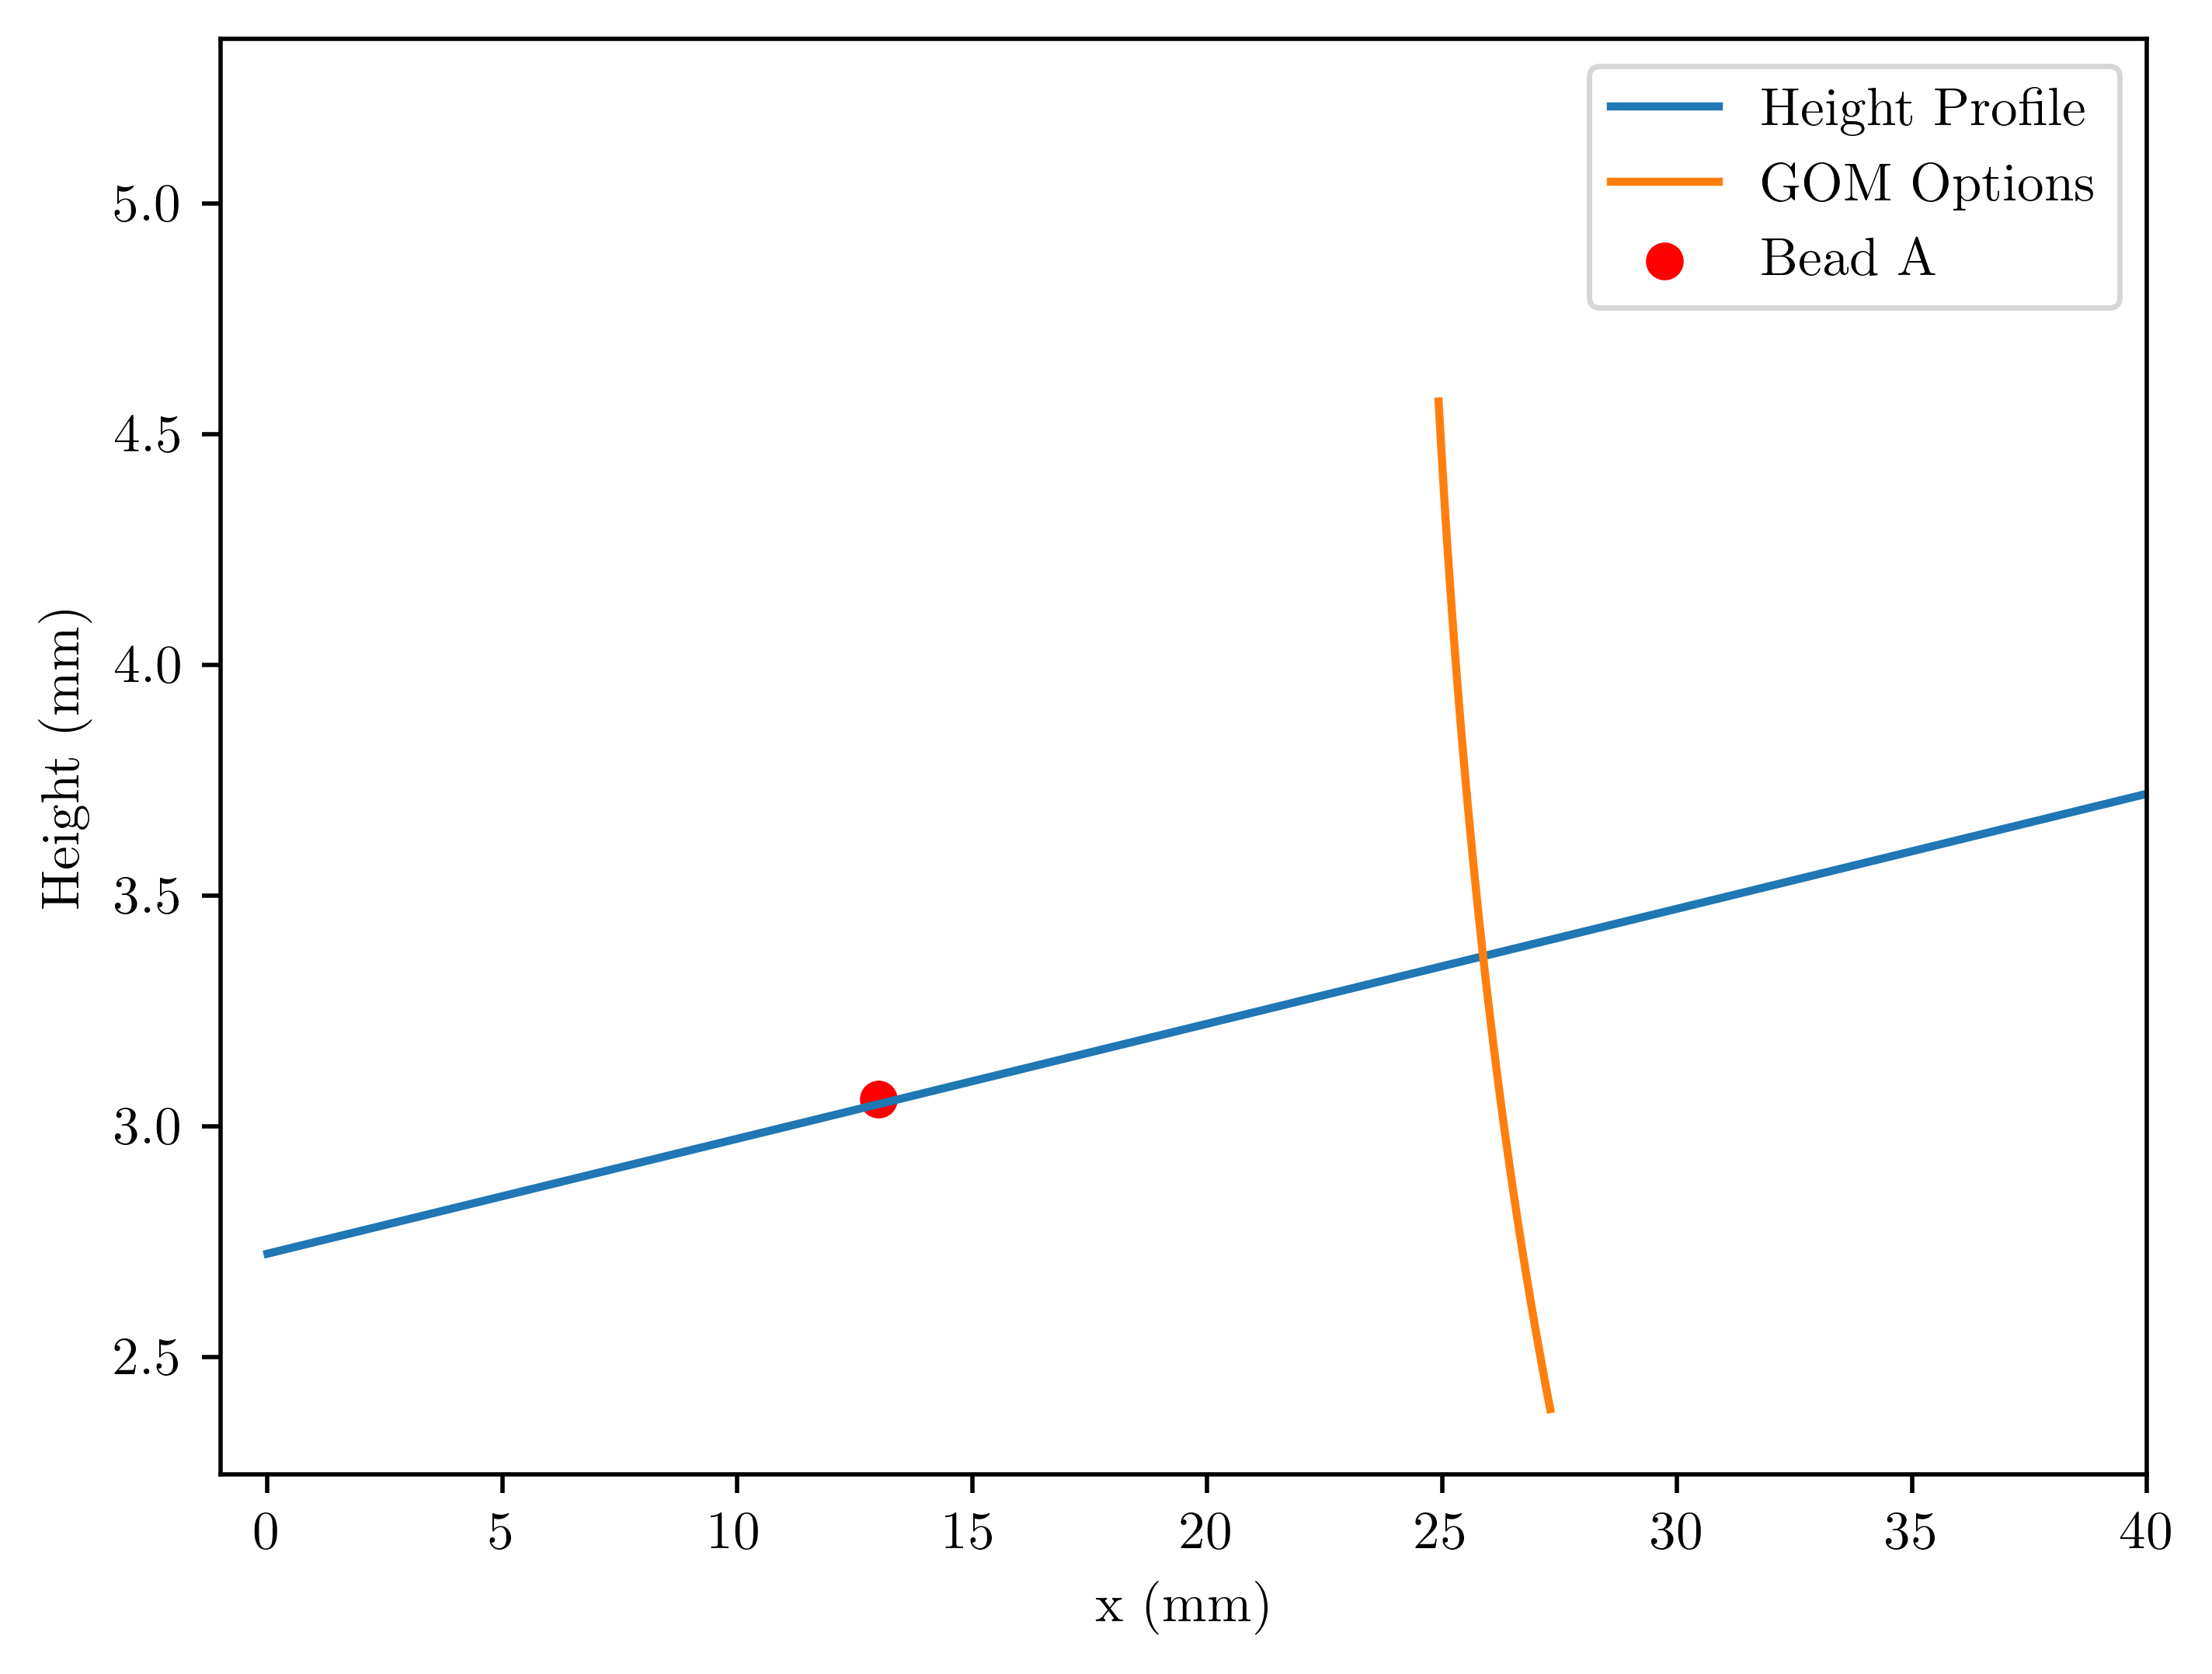

In [54]:
height_profile = [min_dH, max_dH]
x_profile = [0, 100]
v_ts = np.linspace(15,5)

v_w = 230
v_w_fill = 280
v_t_fill = 5
vRatFill = (v_w_fill/39.37)/(v_t_fill*0.06)

vRatStart = (v_w/39.37)/(v_ts[0]*0.06)
vRat = (v_w/39.37)/(v_ts*0.06)

d_s = distance_out(vRatStart, v2dh_loglog(v_ts[0], v_w), vRat, v2dh_loglog(v_ts, v_w), vRatFill, rad_wire=1.2/2)

print(d_s)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig,ax = plt.subplots(1,1)
ax.plot(x_profile, height_profile, label='Height Profile')
ax.plot(d_s+13, v2dh_loglog(v_ts, v_w), label = 'GOM Options')
ax.scatter(x_profile[0]+13, height_profile[0]+0.335, color = 'r', label='Bead A')
ax.legend()
fig.dpi=500
ax.set_xlabel("x (mm)")
ax.set_ylabel("Height (mm)")
ax.set_xlim([-1, 40])
plt.show()